# 07 - Predictive Model
### Author: Daniel Herrera-Russert
#### March 13, 2025

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from adjustText import adjust_text

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import statsmodels.api as sm
import joblib

## 1. Starting point

To develop a predictive model for geothermal energy yield and return, we will implement **Extreme Gradient Boosting (XGBoost)**, a powerful machine learning algorithm known for its efficiency and performance on structured data. XGBoost is particularly well-suited for this task due to its ability to handle **nonlinear relationships**, **feature interactions**, and **imbalanced datasets**, making it a strong candidate for modeling the complex dependencies in geothermal energy extraction.  

XGBoost offers several advantages over traditional regression techniques:  
- **Captures Feature Interactions**: Automatically learns relationships between variables, which is crucial for spatial and geological data.  
- **Handles Nonlinearity**: Unlike linear models, XGBoost can model complex dependencies in energy yield.  
- **Built-in Regularization**: Reduces overfitting, improving model generalization.  
- **Works with Missing Values**: Can handle gaps in data without requiring extensive imputation.  
- **Feature Importance Ranking**: Helps identify the most influential variables, improving interpretability.  

---

### 1.1. Implementation Plan  
1. **Preprocess the dataset**:  
   - Use the transformed dataset, which includes borehole density, depth, bottom elevation, and nearest borehole distance.  
   - Normalize and encode necessary features.  
   - Split the data into **training (80%) and test (20%) sets**.  

2. **Train the XGBoost model**:  
   - Initialize the model with default parameters.  
   - Perform **hyperparameter tuning** using grid search or Bayesian optimization to improve performance.  
   - Train the model using **cross-validation** to ensure robustness.  

3. **Evaluate the model**:  
   - Use **Root Mean Squared Error (RMSE)** and **R² Score** to measure predictive accuracy.  
   - Analyze **feature importance** to determine which variables influence geothermal energy yield the most.  

4. **Refinement and deployment**:  
   - If necessary, refine feature selection or adjust model parameters.  
   - Once validated, prepare the model for use in decision-support applications.  

---

## 2. Building an XGBoost model to predict energy yield

We will preprocess the dataset, split it into training and testing sets, and fine-tune the model using cross-validation and hyperparameter optimization. Key evaluation metrics such as **R² score, RMSE, and MAE** will be used to assess model performance.

In [4]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_probes_with_density_elevation.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)
zh_geothermal_probes_gdf.head()

,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,count_100m,nearest_borehole_dist,count_100m_norm,nearest_borehole_dist_norm,count_100m_normalized,nearest_borehole_dist_normalized,bottom_elevation,top_elevation,geometry
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,6,42.580489,0.098361,0.022562,0.098361,0.022562,315.4,565.4,POINT (2684788.902 1248344.823)
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,1,86.104299,0.016393,0.045623,0.016393,0.045623,319.3,569.3,POINT (2684961.902 1248288.82)
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,7,11.402368,0.114754,0.006042,0.114754,0.006042,317.9,567.9,POINT (2684632.902 1248534.826)
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,7,7.615773,0.114754,0.004035,0.114754,0.004035,316.0,566.0,POINT (2684625.901 1248525.826)
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,7,7.615773,0.114754,0.004035,0.114754,0.004035,314.5,564.5,POINT (2684622.901 1248518.826)


The following correlation matrix shows the breakdown of variables that have been chosen as features for the model, and their effect on the target variable:

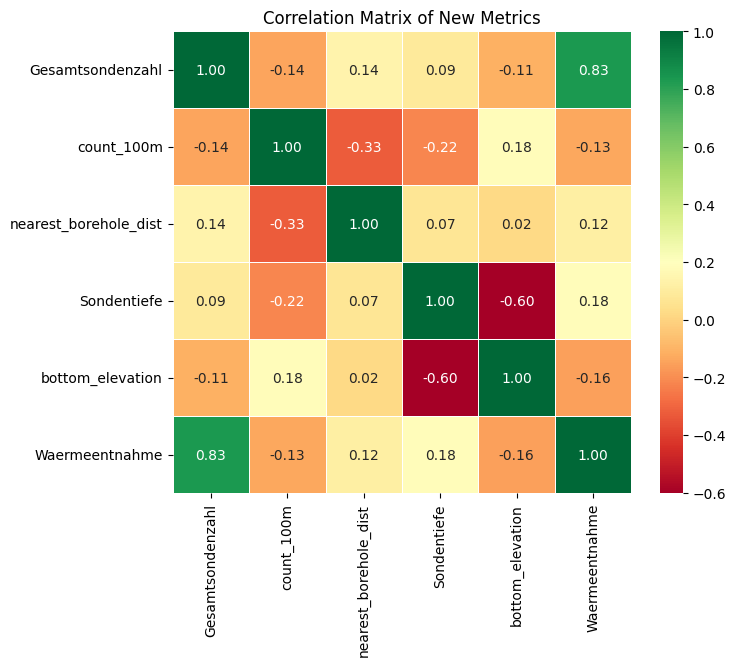

In [5]:
# Select relevant numerical columns for correlation
corr_columns = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation", "Waermeentnahme"]
corr_matrix = zh_geothermal_probes_gdf[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(7.4, 6))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", fmt=".2f", linewidths=0.5)

# Titles and labels
plt.title("Correlation Matrix of New Metrics")
plt.savefig("plots/07_01_cor_matrix_features.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

**Selected features**:

- **Gesamtsondenzahl (Total Boreholes at Location)** → Strongest correlation with `Waermeentnahme` (~0.83), making it a key predictor.
- **count_100m (Borehole Density in 100m Radius)** → Captures local borehole competition, which we found to have some effect on heat extraction.
- **nearest_borehole_dist (Distance to Closest Borehole)** → Complements density by considering the nearest borehole effect individually.
- **Sondentiefe (Borehole Depth)** → Very strong correlation (~0.83) with heat extraction, meaning deeper boreholes extract more energy.
- **bottom_elevation (Lowest Elevation of Borehole)** → Shows some correlation (~0.24), likely linked to underground heat characteristics.

**Potential issues**:

- **Multicollinearity check**: `Sondentiefe` and `bottom_elevation` are highly correlated (-0.60). If redundancy becomes an issue, dropping `bottom_elevation` may be an option.
- **Feature Engineering**: Consider interaction terms (e.g., `Sondentiefe` × `count_100m`) to better capture non-linear effects.
- **Normalization/Scaling**: Ensure all features are normalized (especially `Sondentiefe` & `bottom_elevation`) to improve model performance.

In [6]:
# Define features and target
features = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]
target = "Waermeentnahme"

X = zh_geothermal_probes_gdf[features]
y = zh_geothermal_probes_gdf[target]

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42
)

# Perform cross-validation (5 folds)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="r2")

In [8]:
# Train the model on the training set
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Test Set R²: {r2:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")

Cross-validation R² scores: [0.86537924 0.79771593 0.91362564 0.92288684 0.70484647]
Mean CV R²: 0.8409
Test Set R²: 0.7151
Test Set RMSE: 14.2092
Test Set MAE: 3.2353


The above results indicate that the XGBoost model performs quite well with some room for further optimization.

The cross-validation scores range from **0.70 to 0.91**, with an average of **0.84**, suggesting that the model generalizes well across different subsets of the data. However, the test set $R^2$ score is **0.7151**, meaning that **71.5% of the variance** in energy extraction is explained by the model. While this indicates a relatively strong fit, it also suggests that other factors may influence the target variable that are not yet captured in the model.

Regarding error metrics, the Root Mean Squared Error (RMSE) is **14.21**, which represents the typical prediction error in kW. The lower the RMSE, the better, but it should be interpreted relative to the range of energy extraction values in the dataset. The Mean Absolute Error (MAE) is **3.24**, meaning that, on average, the model’s predictions deviate by about **3.24 kW** from actual values. This is a more interpretable metric than RMSE, but both should be considered together.

To improve performance, the next steps include refining feature selection, adding potential interaction terms, performing hyperparameter tuning, and analyzing residual plots to check for systematic biases.

---

## 2.1. Hyperparameter tuning

This section performs a randomized hyperparameter search using the XGBoost settings and cross-validation to optimize the model for predicting the target geothermal energy yield variable.

The way this is done is firstly by defining a dictionary `param_dist` to specify the ranges for the hyperparameters of the `XGBRegressor`. The search space includes:

- `n_estimators`: Number of boosting rounds (from 50 to 500, step 50)
- `learning_rate`: Learning rate (from 0.01 to 0.3)
- `max_depth`: Maximum depth of each tree (3 to 12)
- `subsample`: Proportion of training instances used in each boosting round
- `colsample_bytree`: Proportion of features used per tree
- `gamma`: Minimum loss reduction to make a further partition
- `reg_alpha`: L1 regularization (log-scaled)
- `reg_lambda`: L2 regularization (log-scaled)



In [10]:
# Define parameter grid
param_dist = {
    "n_estimators": np.arange(50, 500, 50),
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "max_depth": np.arange(3, 12, 1),
    "subsample": np.linspace(0.5, 1, 5),
    "colsample_bytree": np.linspace(0.5, 1, 5),
    "gamma": np.linspace(0, 5, 10),
    "reg_alpha": np.logspace(-3, 1, 5),
    "reg_lambda": np.logspace(-3, 1, 5)
}

An XGBoost regressor is initialized with `objective="reg:squarederror"` for regression tasks.

Using `RandomizedSearchCV` to sample 50 random combinations of hyperparameters:
- `scoring="r2"` optimizes for R² performance
- `cv=5` applies 5-fold cross-validation
- `n_jobs=-1` utilizes all available processors
- `random_state=42` ensures reproducibility

In [11]:
# Initialize base XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random samples to try
    scoring="r2",  # Optimize for R² score
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all available processors
    random_state=42
)

The `fit()` method runs the randomized search on the training dataset. The best model and score are extracted using:
- `random_search.best_estimator_`: The best XGBoost model
- `random_search.best_params_`: The best hyperparameter combination
- `random_search.best_score_`: The corresponding R² score from cross-validation

In [12]:
# Fit randomized search on training data
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best R² score:", random_search.best_score_)

# Use the best model for predictions
best_xgb_model = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': np.float64(0.625), 'reg_lambda': np.float64(10.0), 'reg_alpha': np.float64(1.0), 'n_estimators': np.int64(250), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.042222222222222223), 'gamma': np.float64(2.2222222222222223), 'colsample_bytree': np.float64(1.0)}
Best R² score: 0.8489090792595487


And same as with the original iteration of the XGBoost, predictions are made for the test subset, and saved to the `y_pred` variable for comparison with the original `y_test` values.

In [13]:
# Make predictions using the best model
y_pred = best_xgb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"Best XGBoost Model Performance:")
print(f"Test Set R² Score: {r2:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set MAE: {mae:.4f}")

Best XGBoost Model Performance:
Test Set R² Score: 0.8672
Test Set RMSE: 9.7021
Test Set MAE: 2.8786


After tuning the hyperparameters, the optimized XGBoost model has achieved a **Test Set R² Score of 0.8672**, indicating that approximately **86.72% of the variance in energy yield** is explained by the selected features. This represents a significant improvement over previous iterations.  

The model's **Root Mean Squared Error (RMSE) is 9.7021**, meaning that, on average, the predictions deviate by about **9.7 kW** from actual values. Additionally, the **Mean Absolute Error (MAE) is 2.8786**, suggesting that the typical absolute prediction error is **around 2.88 kW**. 

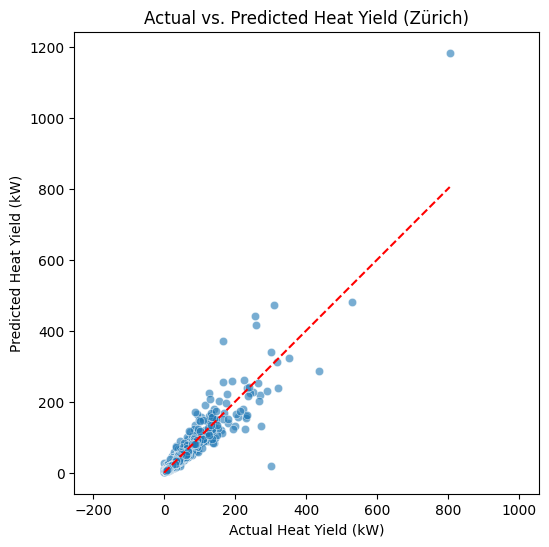

In [27]:
# Plot actual vs. predicted values
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Ideal diagonal line
plt.xlabel("Actual Heat Yield (kW)")
plt.ylabel("Predicted Heat Yield (kW)")
plt.axis("equal")
plt.title("Actual vs. Predicted Heat Yield (Zürich)")

plt.savefig("plots/07_02_actual_pred.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

The **actual vs. predicted** plot shows a strong alignment of predicted values with the actual energy yield values, as indicated by the clustering of points around the red diagonal reference line. This suggests that the model performs well in capturing the variance in the dataset, especially for average values. However, some deviations occur at higher energy yield values, indicating potential underestimation or overestimation in extreme cases. This is likely influenced by the extreme outlying value located at the top right corner, which most likely correlates with the deep geothermal installation in Triemli.

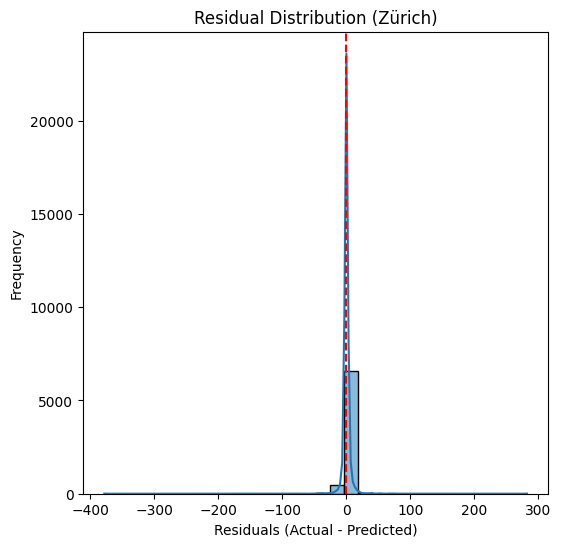

In [26]:
# Compute residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(6,6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')  # Zero error line
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Zürich)")

plt.savefig("plots/07_03_residual_dist.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/07_03_residual_dist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

The **residual distribution** plot confirms that errors are mostly centered around zero, with a slight right-skew. The residuals are tightly distributed, suggesting that the model does not exhibit strong systematic bias. The presence of minor outliers at the extremes suggests that further fine-tuning, feature engineering, or adjustments to hyperparameters could improve predictive performance for edge cases. Again, based on the assessment of the previous plot, it can be added that most deviations from actual values happen at larger heat yield values, suggesting a robust performance for value ranges that comprise the majority of the data.

We can now save the model to the local directory, and import it later on in the UI-application for GeoWatt.

In [16]:
# Save the trained model to a file
joblib.dump(best_xgb_model, "../models/xgb_zh_energy_yield.pkl")

['../models/xgb_zh_energy_yield.pkl']

---

## 3. Assessing Performance of the Model

In [17]:
import shap

In [18]:
# Initialize SHAP explainer
explainer = shap.Explainer(best_xgb_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

100%|===================| 7115/7134 [01:09<00:00]        

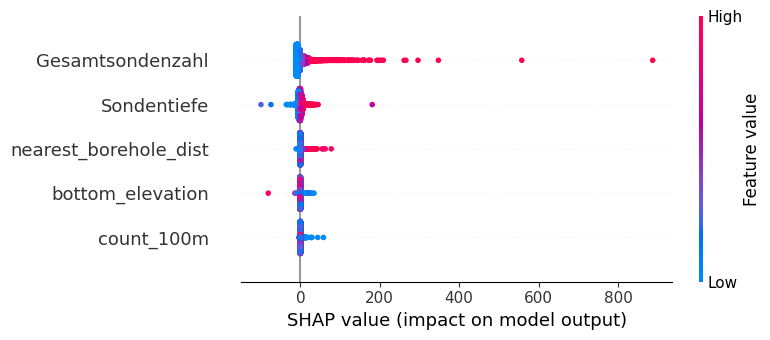

In [19]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot the SHAP summary (show it inside Jupyter)
shap.summary_plot(shap_values, X_test, show=False)

plt.savefig('plots/07_06_shap_overview.png', dpi=300, bbox_inches='tight')
plt.show()

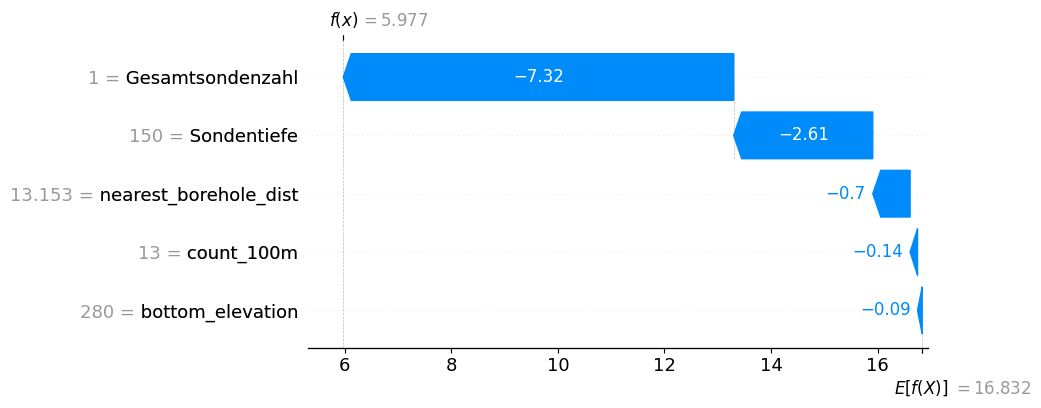

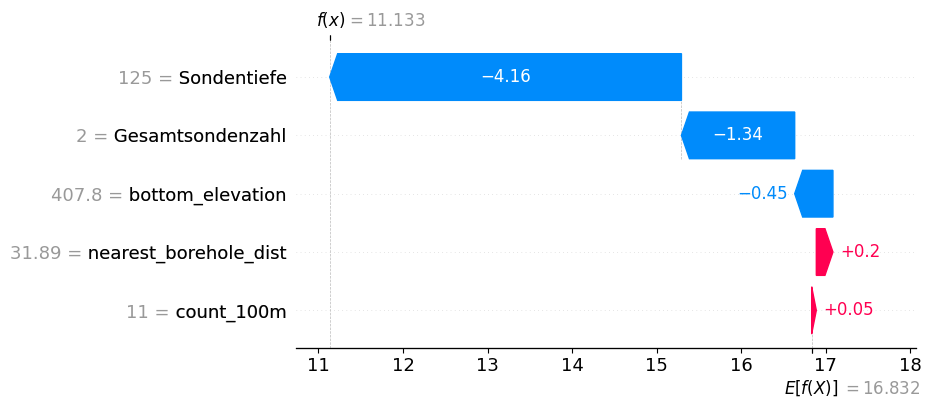

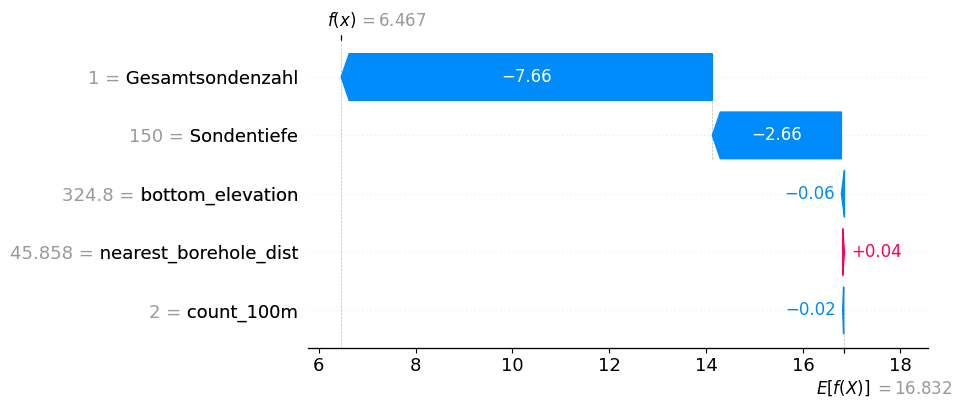

In [25]:
errors_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred,
})
errors_df["AbsResidual"] = abs(errors_df["y_true"] - errors_df["y_pred"])

worst_preds = errors_df.sort_values("AbsResidual", ascending=False).reset_index(drop=True)
idx = range(0, 3)  # top 3 worst predictions

for i in idx:
    plt.figure(figsize=(10, 5))  # Fixed width and height for consistency
    shap.plots.waterfall(shap_values[i], show=False)
    plt.savefig(f"plots/07_06_shap_worst_prediction_0{i+1}.png", dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 640x480 with 0 Axes>

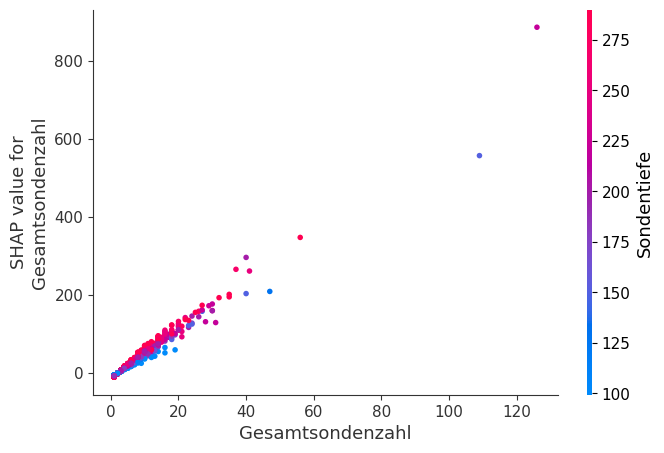

Saved plot: plots/07_06_shap_features_01.png


<Figure size 640x480 with 0 Axes>

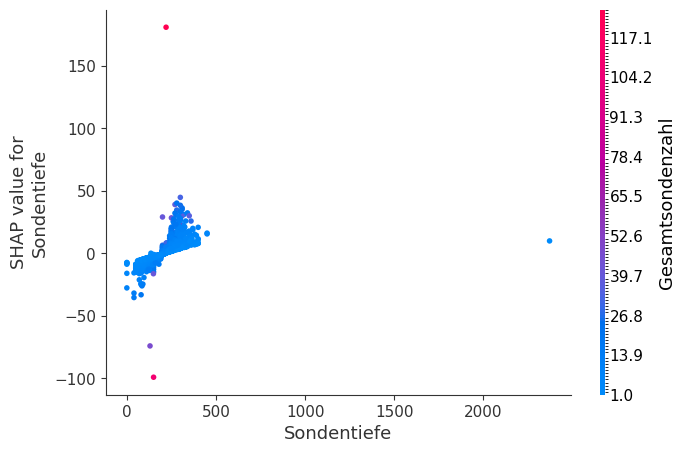

Saved plot: plots/07_06_shap_features_02.png


<Figure size 640x480 with 0 Axes>

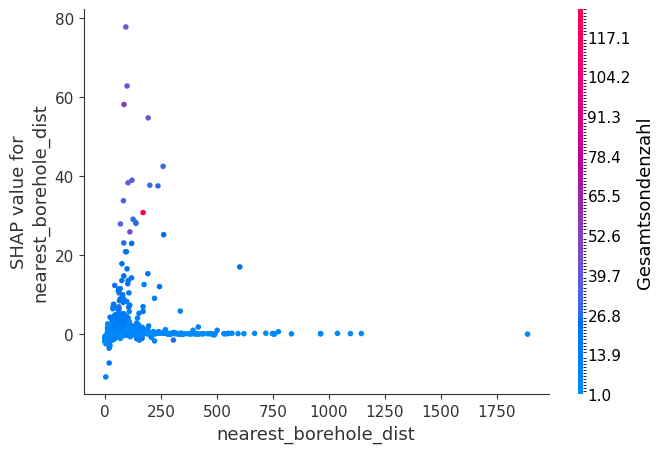

Saved plot: plots/07_06_shap_features_03.png


<Figure size 640x480 with 0 Axes>

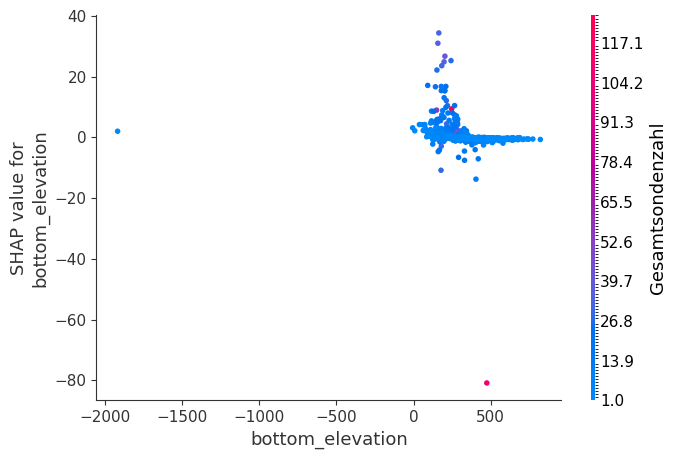

Saved plot: plots/07_06_shap_features_04.png


<Figure size 640x480 with 0 Axes>

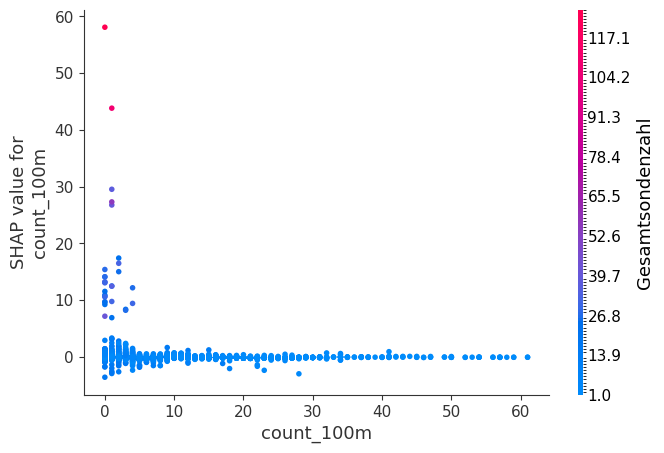

Saved plot: plots/07_06_shap_features_05.png


In [33]:
# List your features in order (from summary plot)
features_order = ["Gesamtsondenzahl", "Sondentiefe", "nearest_borehole_dist", "bottom_elevation", "count_100m"]

# Loop through and plot
for i, feature in enumerate(features_order, start=1):
    plt.figure()  # Start a new figure
    shap.dependence_plot(
        feature, shap_values.values, X_test, show=False  # Important: show=False to not immediately display
    )

    # Save the plot
    filename = f"plots/07_06_shap_features_{i:02d}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the plot to avoid overlap
    print(f"Saved plot: {filename}")

---

## 4. Accuracy Diagnostics

The first impression after having built the XGBoost model is that it performs surprisingly well at predicting the values from the dataset, partly due to the correct implementation of the engineered spatial variables, as well as the known capabilities of the algorithm at capturing complex nonlinear patterns in the training data. As a follow-up on this, we now proceed with identifying what other factors, geographical or others, can explain the varying accuracy of results accross the dataset. For this purpose, we will next produce a prediction of all values on the dataset, and visualize the accuracy patterns at a geographic scale, which may illustrate how perhaps more complex factors such as installations being located in rural locations, or along the coastline of lake of Zürich, may be behind the clustering of mismaches.

In [14]:
# Reload the borehole dataset and save as GeoPandas
geojson_path = "../data/transformed/zh_geothermal_probes_with_density_elevation.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)
zh_geothermal_probes_gdf.head()

# Load the model
model_path = "../models/xgb_zh_energy_yield.pkl"
xgb_model = joblib.load(model_path)

We now run the predictions with the model again:

In [15]:
# Define features and target
feature_columns = ["Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]

# Make predictions
X = zh_geothermal_probes_gdf[feature_columns]
y_pred = xgb_model.predict(X)

# Store predictions in a new column
zh_geothermal_probes_gdf.loc[zh_geothermal_probes_gdf.index, 'Waermeentnahme_predicted'] = y_pred

A new variable `accuracy_score` is created, which reflects the local accuracy at each row: 

$$
\text{accuracy\_score}_i = 1 - \frac{|\hat{y}_i - y_i|}{y_i + \varepsilon}
$$

Where:
- $\hat{y}_i$ is the predicted value (`Waermeentnahme_predicted`)
- $y_i $ is the actual value (`Waermeentnahme`)
- $\varepsilon$ is a small constant to avoid division by zero (e.g., $ 10^{-5} $)
- The score is clipped to the range $[0, 1]$

In [16]:
# Compute local accuracy score: 1 - relative error
zh_geothermal_probes_gdf['abs_error'] = abs(
    zh_geothermal_probes_gdf['Waermeentnahme_predicted'] - zh_geothermal_probes_gdf['Waermeentnahme']
)

# Avoid division by zero by adding a small epsilon
epsilon = 1e-5
zh_geothermal_probes_gdf['accuracy_score'] = 1 - (
    zh_geothermal_probes_gdf['abs_error'] / (zh_geothermal_probes_gdf['Waermeentnahme'] + epsilon)
)

# Clip values to [0, 1] for sanity
zh_geothermal_probes_gdf['accuracy_score'] = zh_geothermal_probes_gdf['accuracy_score'].clip(0, 1)

In [85]:
# Load and ensure Zürich boundary is in LV95
boundary_gdf = gpd.read_file("../data/raw/zh_boundary.geojson").to_crs("EPSG:2056")
boundary_polygon = boundary_gdf.geometry.union_all()  # Returns a single shapely object

# Load Gemeinde boundaries
gemeinden_gdf = gpd.read_file("../data/raw/zh_gemeinden.geojson")
gemeinden_gdf = gemeinden_gdf.to_crs(zh_geothermal_probes_gdf.crs)

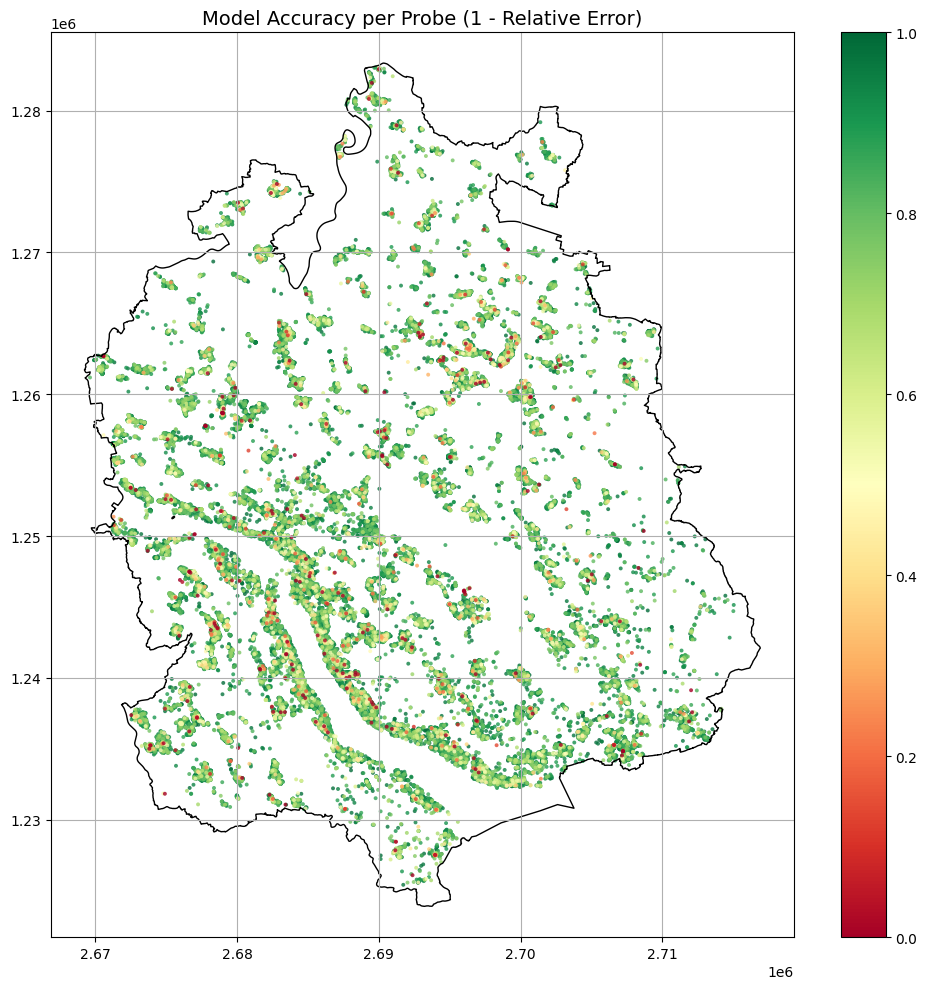

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))

# Filter only points that have an accuracy score
points_with_accuracy = zh_geothermal_probes_gdf.dropna(subset=['accuracy_score'])

# Sort so lowest accuracy is plotted last (on top)
points_sorted = points_with_accuracy.sort_values(by='accuracy_score', ascending=False)

# Plot the points
points_sorted.plot(
    ax=ax,
    column="accuracy_score",
    cmap="RdYlGn",
    markersize=8,
    legend=True,
    linewidth=0,
    edgecolor="none",
    alpha=0.8,
    vmin=0.0,
    vmax=1.0
)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

ax.grid(True)
plt.title("Model Accuracy per Probe (1 - Relative Error)", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.savefig("plots/07_04_accuracy_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

The generally green-leaning colors of the accuracy-per-probe plot reflect the good performance of the model. It does become apparent that there are scattered low values, sometimes even close to 0, presumably indicating that for these locations the predicted heat yield value was missassigned a very low value or even 0.

We can now have a closer look at some of these wrong predictions, to assess what other data is populating the predictor columns.

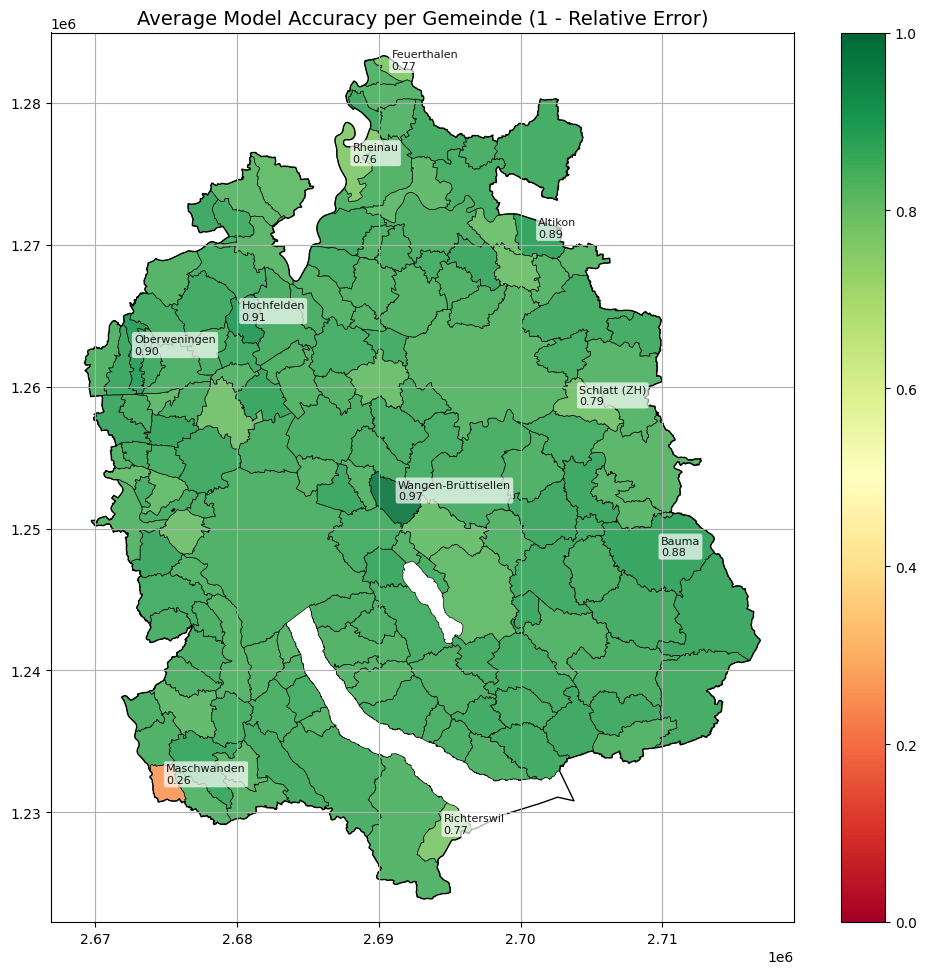

In [47]:
# Spatial join to assign Gemeinde to each probe
probes_with_gemeinde = gpd.sjoin(
    zh_geothermal_probes_gdf,
    gemeinden_gdf[['NAME', 'geometry']],
    how='left',
    predicate='within'
)

# Aggregate accuracy score per Gemeinde
gemeinde_accuracy = probes_with_gemeinde.groupby("NAME")["accuracy_score"].mean().reset_index()

# Merge accuracy score into Gemeinde GeoDataFrame
gemeinden_with_accuracy = gemeinden_gdf.merge(gemeinde_accuracy, on="NAME")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot aggregated accuracy per Gemeinde
gemeinden_with_accuracy.plot(
    ax=ax,
    column='accuracy_score',
    cmap='RdYlGn',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    alpha=0.9,
    vmin=0.0,
    vmax=1.0
)

# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Select top 5 and bottom 5 Gemeinden by accuracy
top5 = gemeinden_with_accuracy.nlargest(5, 'accuracy_score')
bottom5 = gemeinden_with_accuracy.nsmallest(5, 'accuracy_score')
label_gemeinden = pd.concat([top5, bottom5])

# Add only selected Gemeinde labels with white background (no alignment overrides)
texts = []
for idx, row in label_gemeinden.iterrows():
    point = row['geometry'].representative_point()
    texts.append(
        ax.text(
            point.x,
            point.y,
            f"{row['NAME']}\n{row['accuracy_score']:.2f}",
            fontsize=8,
            color='black',
            alpha=0.9,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.7)
        )
    )

# Layout settings
ax.grid(True)
plt.title("Average Model Accuracy per Gemeinde (1 - Relative Error)", fontsize=14)
plt.axis("equal")
plt.tight_layout()

# Save output
plt.savefig("plots/07_04_accuracy_map_gemeinden.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
low_acc = zh_geothermal_probes_gdf[zh_geothermal_probes_gdf['accuracy_score'] < 0.5]
high_acc = zh_geothermal_probes_gdf[zh_geothermal_probes_gdf['accuracy_score'] >= 0.5]

features = ["Waermeentnahme", "Gesamtsondenzahl", "count_100m", "nearest_borehole_dist", "Sondentiefe", "bottom_elevation"]

In [50]:
from esda.moran import Moran_Local
from libpysal.weights import Queen
import matplotlib.pyplot as plt

# Create spatial weights
w = Queen.from_dataframe(zh_geothermal_probes_gdf)
w.transform = 'r'

# Calculate Local Moran's I
lisa = Moran_Local(zh_geothermal_probes_gdf['accuracy_score'], w)

# Add LISA results to your GeoDataFrame
zh_geothermal_probes_gdf['lisa_I'] = lisa.Is
zh_geothermal_probes_gdf['lisa_q'] = lisa.q  # quadrant type
zh_geothermal_probes_gdf['lisa_p'] = lisa.p_sim

# Filter significant only
zh_geothermal_probes_gdf['lisa_sig'] = zh_geothermal_probes_gdf['lisa_p'] < 0.05

C:\Users\leina\AppData\Local\Temp\ipykernel_6316\247937991.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(zh_geothermal_probes_gdf)


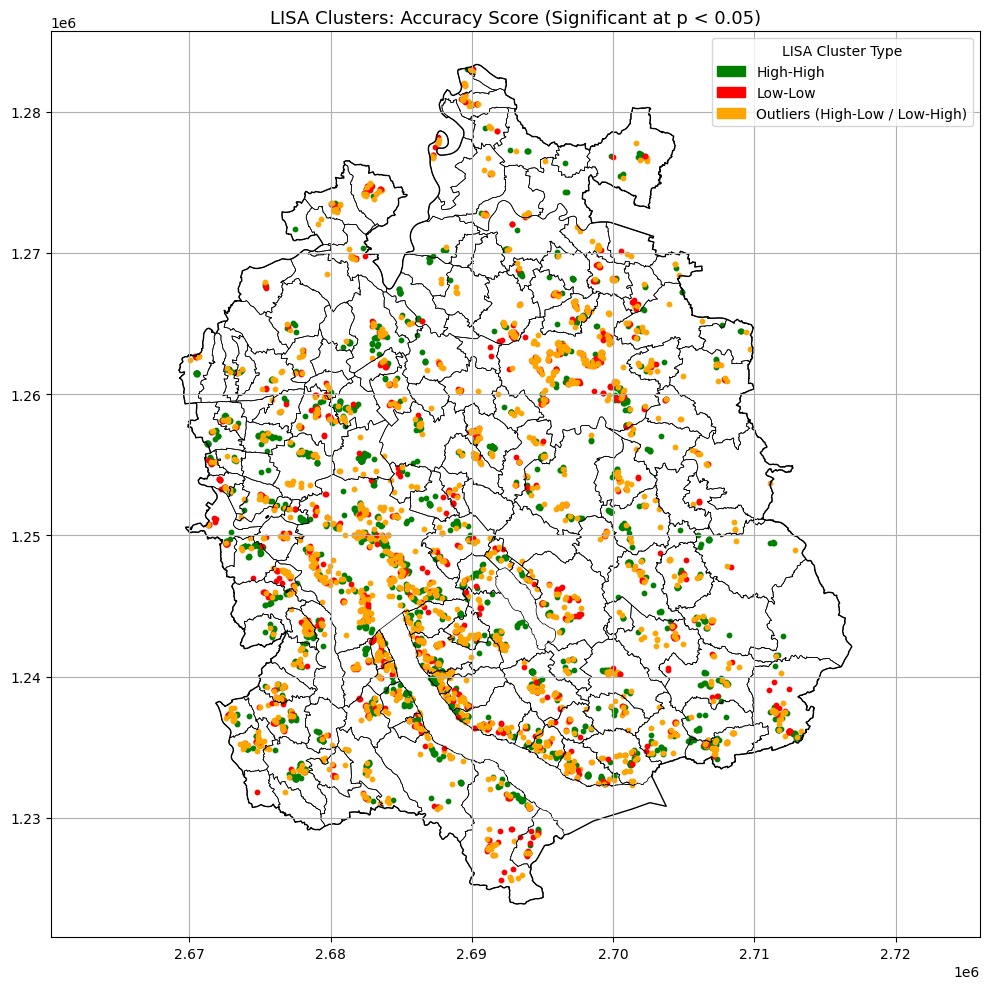

In [82]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

# Group LH and HL under the same color
colors = {
    1: 'green',   # High-High
    2: 'orange',  # Low-High
    3: 'red',     # Low-Low
    4: 'orange'   # High-Low
}

# Filter only significant observations
significant = zh_geothermal_probes_gdf[zh_geothermal_probes_gdf['lisa_sig']]

# Plot each cluster type separately for custom legend
for q, color in colors.items():
    subset = significant[significant['lisa_q'] == q]
    if not subset.empty:
        subset.plot(ax=ax, color=color, markersize=10, label={
            1: "High-High",
            2: "Low-High (Outlier)",
            3: "Low-Low",
            4: "High-Low (Outlier)"
        }[q])


# Overlay canton boundary
boundary_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
gemeinden_gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

# Custom legend handles
legend_patches = [
    mpatches.Patch(color='green', label='High-High'),
    mpatches.Patch(color='red', label='Low-Low'),
    mpatches.Patch(color='orange', label='Outliers (High-Low / Low-High)')
]

# Plot legend
ax.legend(handles=legend_patches, loc='upper right', title="LISA Cluster Type")

# Layout and formatting
plt.title("LISA Clusters: Accuracy Score (Significant at p < 0.05)", fontsize=13)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/07_05_lisa_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [59]:
group_map = {
    1: 'High-High',
    2: 'Outlier',
    3: 'Low-Low',
    4: 'Outlier'
}

# Assign group labels
zh_geothermal_probes_gdf['lisa_group'] = zh_geothermal_probes_gdf['lisa_q'].map(group_map)
zh_geothermal_probes_gdf.loc[~zh_geothermal_probes_gdf['lisa_sig'], 'lisa_group'] = 'Non-significant'

# Now group and calculate feature means
grouped_features = zh_geothermal_probes_gdf.groupby('lisa_group')[
    ["Gesamtsondenzahl", "Sondentiefe", "nearest_borehole_dist", "bottom_elevation", "count_100m"]
].mean().T  # transpose for easy plotting

C:\Users\leina\AppData\Local\Temp\ipykernel_6316\2277209678.py:91: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


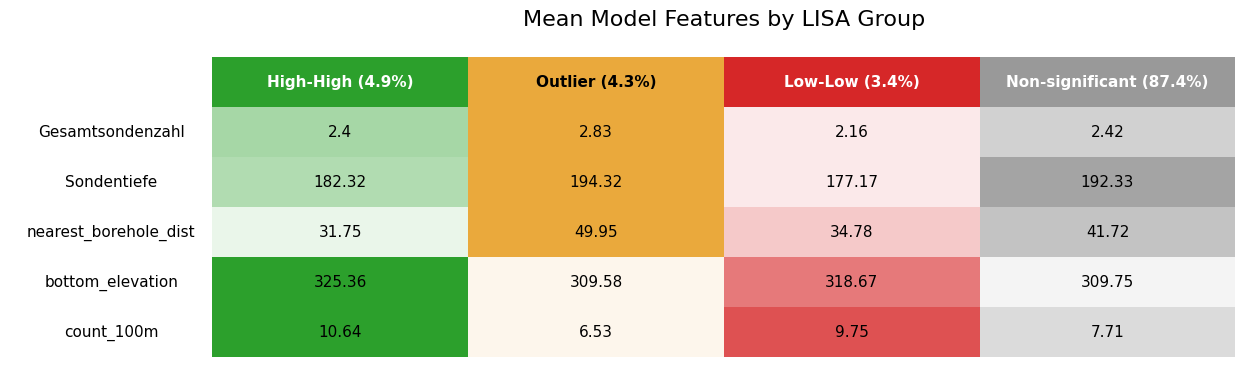

In [136]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Reorder columns for visual logic
column_order = ['High-High', 'Outlier', 'Low-Low', 'Non-significant']
grouped_features = grouped_features[column_order]

# Define base LISA group colors
col_colors = {
    'High-High': '#2ca02c',        # green
    'Outlier': '#EAA93C',          # yellow
    'Low-Low': '#d62728',          # red
    'Non-significant': '#999999'   # gray
}
column_colors = [col_colors[col] for col in column_order]

# --- NEW: Calculate percentages for column headers ---
group_counts = zh_geothermal_probes_gdf['lisa_group'].value_counts(normalize=True)
column_labels = [
    f"{label} ({group_counts.get(label, 0)*100:.1f}%)"
    for label in column_order
]

# Normalize feature values row-wise (per feature)
normalized = (grouped_features.T - grouped_features.min(axis=1)) / (
    grouped_features.max(axis=1) - grouped_features.min(axis=1)
)
normalized = normalized.T.fillna(0)

# Prepare data for table
table_data = grouped_features.round(2).values.tolist()
row_labels = grouped_features.index.tolist()

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')

# Create the table
table = ax.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=column_labels,  # <-- now includes %
    loc='center',
    cellLoc='center',
    rowLoc='center'
)

table.set_fontsize(16)     # Large, clear text
table.scale(2.2, 3)       # Bigger cells to match

# Apply LISA group color with per-row intensity
n_rows, n_cols = len(table_data), len(column_order)
for col_idx, col_name in enumerate(column_order):
    base_rgb = mcolors.to_rgb(col_colors[col_name])
    
    # Create a light version of the base color
    light_rgb = [1 - 0.1 * (1 - c) for c in base_rgb]  # blend 10% color with white
    
    for row_idx in range(n_rows + 1):  # +1 for header
        cell = table[row_idx, col_idx]
        
        if row_idx == 0:
            # Header styling
            header_text_color = 'black' if col_name == 'Outlier' else 'white'
            cell.set_facecolor(col_colors[col_name])
            cell.set_text_props(
                color=header_text_color,
                weight='bold'
            )
        else:
            # Apply gradient based on normalized value
            alpha = normalized.iloc[row_idx - 1, col_idx]
            blended_color = tuple(
                (1 - alpha) * light + alpha * full
                for light, full in zip(light_rgb, base_rgb)
            )
            cell.set_facecolor(blended_color)
            cell.set_text_props(color='black')

# Optional: row label styling
for row_idx in range(1, n_rows + 1):
    row_label = table[row_idx, -1]
    row_label.set_text_props(weight='normal')

# Remove all cell borders
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)

# Title
plt.tight_layout()
plt.title("Mean Model Features by LISA Group", fontsize=16, pad=20)
plt.savefig("plots/07_06_lisa_table.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
low_acc[features].median()

Waermeentnahme             6.000000
Gesamtsondenzahl           2.000000
count_100m                 6.000000
nearest_borehole_dist     29.470587
Sondentiefe              190.000000
bottom_elevation         302.800000
dtype: float64

In [21]:
high_acc[features].median()

Waermeentnahme            10.000000
Gesamtsondenzahl           1.000000
count_100m                 6.000000
nearest_borehole_dist     28.461448
Sondentiefe              195.000000
bottom_elevation         298.600000
dtype: float64

The next step is to visualise this information on the hexagonal grid GeoJSON for Kanton Zürich, as this will help with assessing the performance on a more controllable scale, particularly for producing a histogram.

In [22]:
# Load hex grid
hex_gdf = gpd.read_file("../data/transformed/hex_zh_empty.geojson")

# Load and ensure Zürich boundary is in LV95
boundary_gdf = gpd.read_file("../data/raw/zh_boundary.geojson").to_crs("EPSG:2056")

# Merge into single polygon
boundary_polygon = boundary_gdf.geometry.union_all()  # Returns a single shapely object

# EPSG:2056 = CH1903+ / LV95 (Swiss grid)
target_crs = "EPSG:2056"

zh_geothermal_probes_gdf.crs = "EPSG:2056"  # Assign CRS without modifying data
hex_gdf = hex_gdf.to_crs(target_crs)

# Ensure both GeoDataFrames use the same CRS
assert hex_gdf.crs == zh_geothermal_probes_gdf.crs, "CRS mismatch!"

In [23]:
# Spatial join: assign each probe to a hexagon
joined_gdf = gpd.sjoin(
    zh_geothermal_probes_gdf[['accuracy_score', 'geometry']],
    hex_gdf[['geometry']],
    how='inner',
    predicate='within'
)

# Group by hexagon geometry and calculate mean accuracy
hex_accuracy = joined_gdf.groupby('index_right').agg(
    mean_accuracy=('accuracy_score', 'mean'),
    probe_count=('accuracy_score', 'count')
).reset_index()

In [24]:
# Merge the stats back into the hex_gdf
hex_gdf['hex_id'] = hex_gdf.index  # Optional: preserve ID for clarity

# Inner merge the data to remove NAs
hex_gdf = hex_gdf.merge(hex_accuracy, left_on='hex_id', right_on='index_right', how='inner')

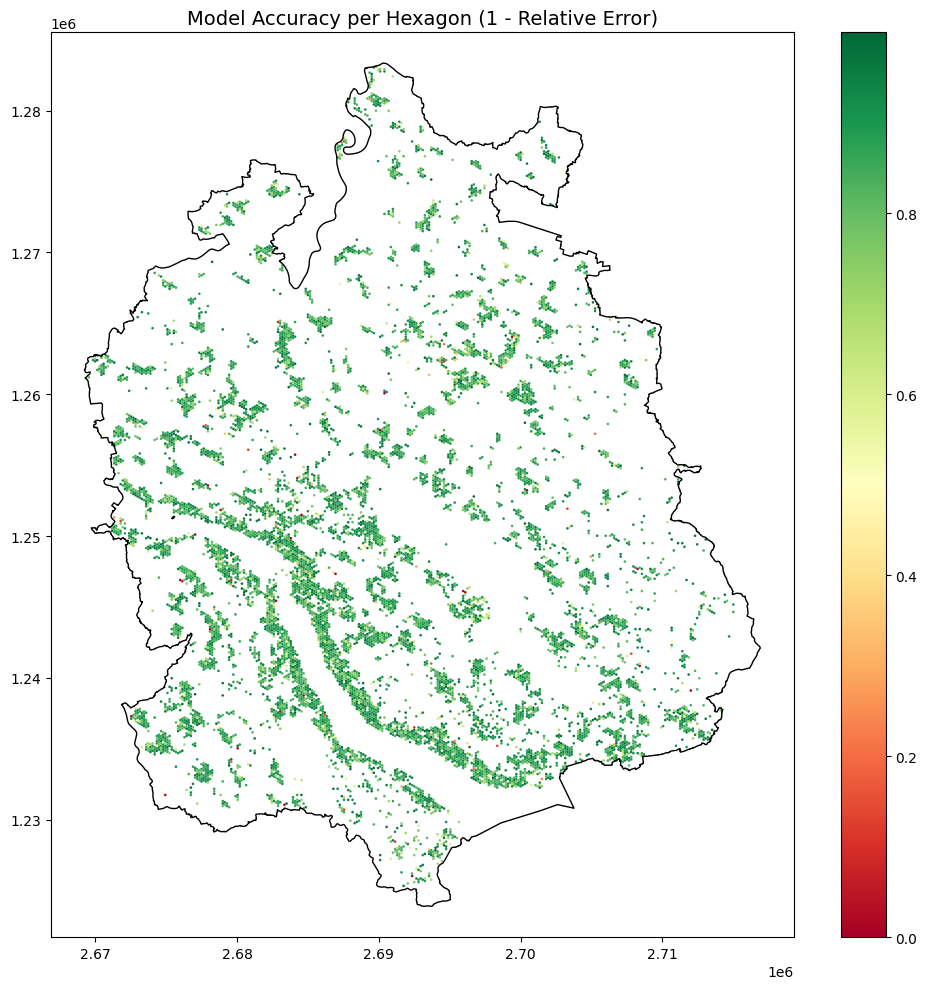

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot hex grid with mean accuracy
hex_gdf.plot(
    ax=ax,
    column="mean_accuracy",
    cmap="RdYlGn",  # Blueish palette for accuracy
    edgecolor="none",
    linewidth=0,
    legend=True
)

# Plot canton boundary
boundary_gdf.plot(ax=ax, color="none", edgecolor="black", linewidth=1)

plt.title("Model Accuracy per Hexagon (1 - Relative Error)", fontsize=14)
plt.axis("equal")
plt.tight_layout()
plt.savefig("plots/07_05_accuracy_hex_map.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/07_05_accuracy_hex_map.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\leina\AppData\Local\Temp\ipykernel_6316\4009779415.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('RdYlGn')(norm(bin_centers))


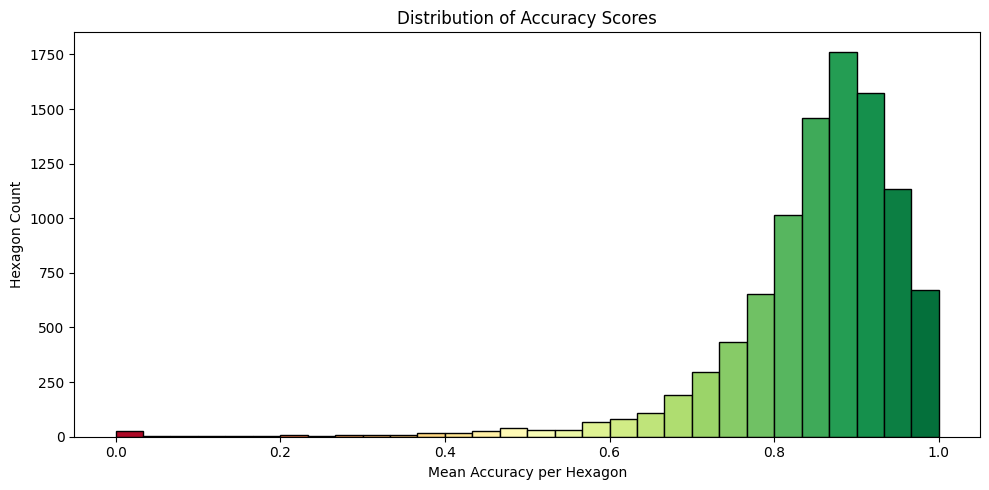

In [26]:
# Extract valid accuracy values
data = hex_gdf[hex_gdf['probe_count'] > 0]['mean_accuracy']

# Create histogram manually so we can color each bin
counts, bins = np.histogram(data, bins=30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Normalize bin centers to [0, 1] for colormap
norm = plt.Normalize(0, 1)
colors = cm.get_cmap('RdYlGn')(norm(bin_centers))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(len(counts)):
    ax.bar(bin_centers[i], counts[i], width=(bins[1] - bins[0]), color=colors[i], edgecolor='black')

ax.set_xlabel("Mean Accuracy per Hexagon")
ax.set_ylabel("Hexagon Count")
ax.set_title("Distribution of Accuracy Scores")
plt.grid(False)
plt.tight_layout()
plt.savefig("plots/07_05_accuracy_hex_hist.svg", format="svg", bbox_inches="tight")
plt.savefig("plots/07_05_accuracy_hex_hist.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

The model shows overall a strong predictive power, likely because the engineered features, such as local probe density `count_100m` and nearest borehole distance `nearest_borehole_dist`, and particularly, the difference between the elevation and depth (`bottom_elevation`) act as proxies for physical phenomena. These variables can implicitly reflect knowledge embedded in planning practices, such as how probe layouts are designed to avoid thermal interference or optimize depth based on expected conditions.

Although the high R-squared suggests the model generalizes well within the dataset, we must consider whether this performance is partially due to overfitting. The use of **cross-validation** and consistent **train/test** results points against it, but spatial clustering and planning-based labels might mean the model is just learning from recurring patterns or local practices, which may not hold in other regions.

A deeper concern is potential bias in the target variable itself. The `Waermeentnahme` values likely stem from professional estimates or planning submissions rather than real-world heat extraction data. As a result, the model might be excellent at reflecting **planning expectations** rather than modelling actual subsurface thermal behaviour. This makes the model valuable as a decision-support tool, and also meets the initial expectations, but limits its interpretation potential as a geophysical predictor.